# 1. Import needed libraries

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Dense, ReLU
from tensorflow.keras.layers import Embedding, BatchNormalization, Concatenate
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# 2. Read and Preprocessing data

### 2.1 Read data

In [54]:
from sklearn.model_selection import train_test_split

# Assuming df is your DataFrame and you want to split based on 'col' column
# You can adjust the test_size and val_size to change the split proportions
train_size = 0.9
test_size = 0.05
val_size = 0.05

df = pd.read_csv('/kaggle/input/ind-proj/decisions.csv')

df = df[['text', 'decision']]

# First split into train and (test + val)
df, test_val_df = train_test_split(df, test_size=(test_size + val_size), random_state=42)

# Then split test_val_df into test and validation sets
test_df, val_df = train_test_split(test_val_df, test_size=val_size/(test_size + val_size), random_state=42)

In [55]:
df

,text,decision
514,the Vanara chiefs and warriors and get them to...,yes
265,and he soon b ecame the favourite of his prece...,yes
54,She turns to the ornithopter. Paul and Leto ex...,no
731,Love sprouted when l was 16. Handsome men were...,no
620,"tiﬁcvalueoftheScandinavianLanguages .Izmo,clot...",no
...,...,...
71,The blood flows from the sliced throats of pri...,no
106,alsointhelaterRecensionsoftheBookoftheDeadwhic...,no
270,Thou shalt then be freed from the condition o...,yes
435,"Vanaras, conveyed to them the king's command. ...",no


In [56]:
df['decision'].unique()

array(['yes', 'no'], dtype=object)

In [57]:
df.decision.value_counts()

decision
no     550
yes    152
Name: count, dtype: int64

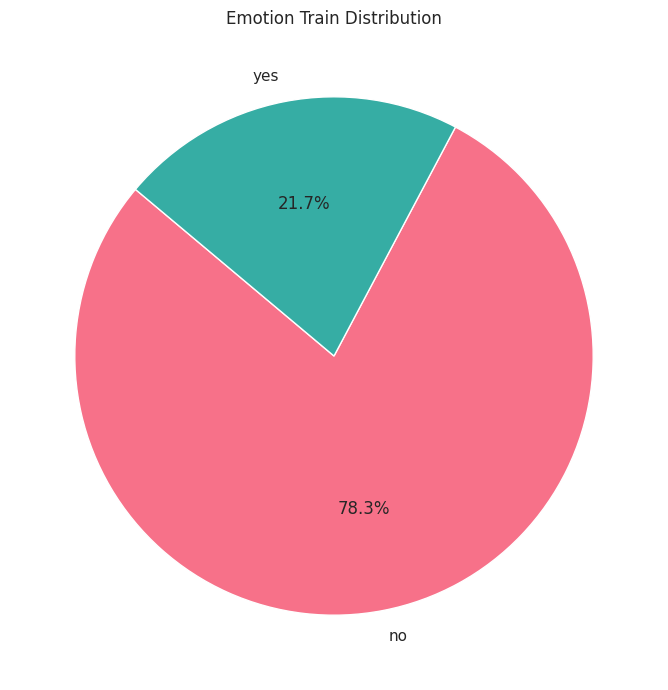

In [58]:
# Count label distributions
label_counts = df['decision'].value_counts()
light_colors = sns.husl_palette(n_colors=len(label_counts))
sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=light_colors)
plt.title('Emotion Train Distribution')
plt.show()

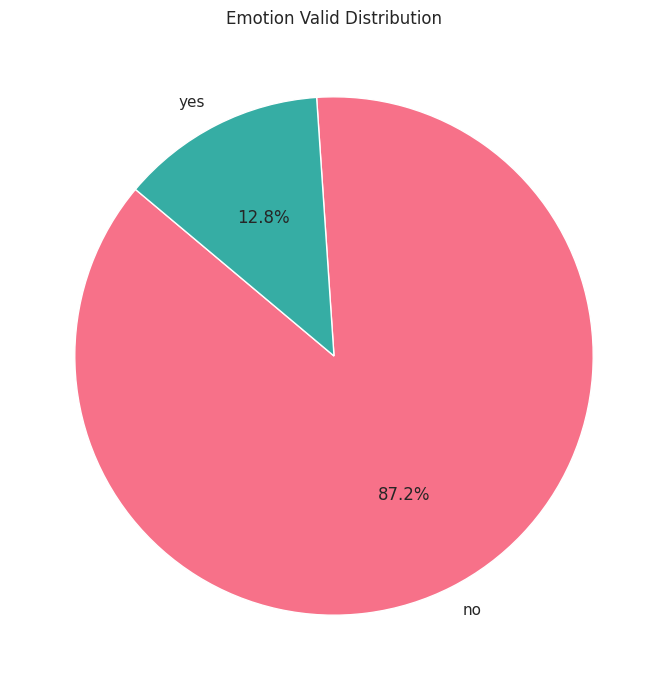

In [59]:
label_counts = val_df['decision'].value_counts()
light_colors = sns.husl_palette(n_colors=len(label_counts))
sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=light_colors)
plt.title('Emotion Valid Distribution')
plt.show()

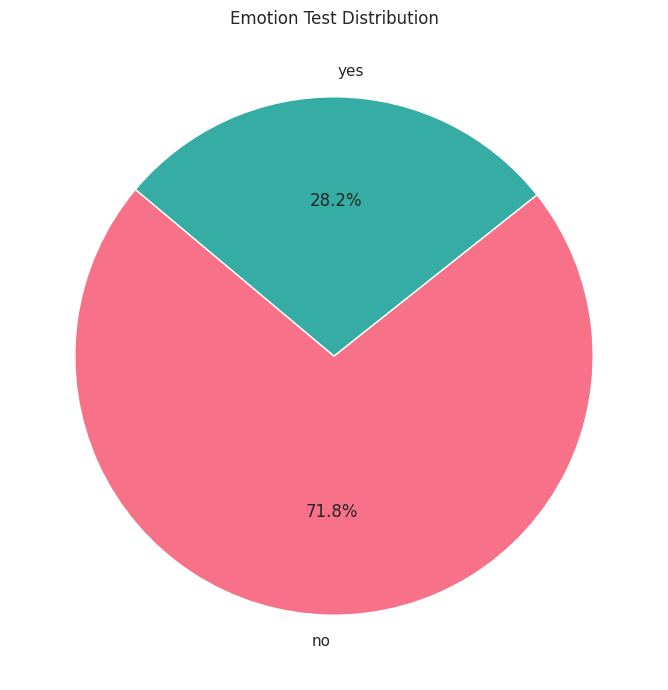

In [60]:
# Count label distributions
label_counts = test_df['decision'].value_counts()
light_colors = sns.husl_palette(n_colors=len(label_counts))
sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=light_colors)
plt.title('Emotion Test Distribution')
plt.show()

### Since we have an unbalanced dataset, we can remove both surprise and love labels since they are the lowest and reduce each label to make the dataset balanced.

In [61]:
df.decision.value_counts()

decision
no     550
yes    152
Name: count, dtype: int64

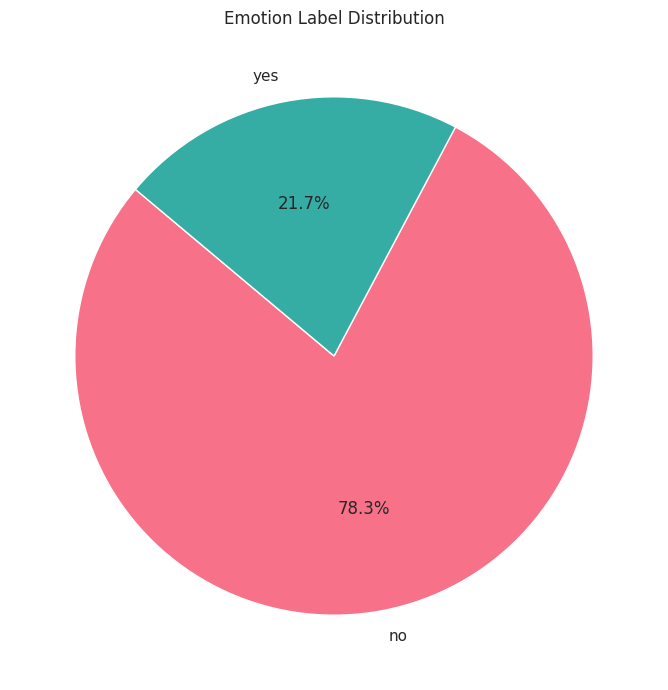

In [62]:
# Count label distributions
label_counts = df['decision'].value_counts()
light_colors = sns.husl_palette(n_colors=len(label_counts))
sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=light_colors)
plt.title('Emotion Label Distribution')
plt.show()

### 2.2 Split data into X, y

In [63]:
tr_text = df['text']
tr_label = df['decision']

val_text = val_df['text']
val_label = val_df['decision']

ts_text = test_df['text']
ts_label = test_df['decision']

### 2.3 Encoding

In [64]:
encoder = LabelEncoder()
tr_label = encoder.fit_transform(tr_label)
val_label = encoder.transform(val_label)
ts_label = encoder.transform(ts_label)

In [65]:
dict(zip(encoder.classes_, range(len(encoder.classes_))))

{'no': 0, 'yes': 1}

### 2.4 Text preprocessing

In [66]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(tr_text) 
                            
sequences = tokenizer.texts_to_sequences(tr_text)

tr_x = pad_sequences(sequences, maxlen=50) 
tr_y = to_categorical(tr_label)

sequences = tokenizer.texts_to_sequences(val_text)
val_x = pad_sequences(sequences, maxlen=50)
val_y = to_categorical(val_label)

sequences = tokenizer.texts_to_sequences(ts_text)
ts_x = pad_sequences(sequences, maxlen=50)
ts_y = to_categorical(ts_label)

# 3. Building deep learning model

In [67]:
max_words = 10000
max_len = 50
embedding_dim = 32

### 3.1 Model architecture

In [75]:
# Branch 1
branch1 = Sequential()
branch1.add(Embedding(max_words, embedding_dim, input_length=max_len))
branch1.add(Conv1D(64, 3, padding='same', activation='relu'))
branch1.add(BatchNormalization())
branch1.add(ReLU())
branch1.add(Dropout(0.5))
branch1.add(GlobalMaxPooling1D())

# Branch 2
branch2 = Sequential()
branch2.add(Embedding(max_words, embedding_dim, input_length=max_len))
branch2.add(Conv1D(64, 3, padding='same', activation='relu'))
branch2.add(BatchNormalization())
branch2.add(ReLU())
branch2.add(Dropout(0.5))
branch2.add(GlobalMaxPooling1D())

concatenated = Concatenate()([branch1.output, branch2.output])

hid_layer = Dense(128, activation='relu')(concatenated)
dropout = Dropout(0.3)(hid_layer)
output_layer = Dense(2, activation='softmax')(dropout)

model = Model(inputs=[branch1.input, branch2.input], outputs=output_layer)

### 3.2 Compile model

In [76]:
model.compile(optimizer='adamax',
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 embedding_6_input (InputLa  [(None, 50)]                 0         []                            
 yer)                                                                                             
                                                                                                  
 embedding_7_input (InputLa  [(None, 50)]                 0         []                            
 yer)                                                                                             
                                                                                                  
 embedding_6 (Embedding)     (None, 50, 32)               320000    ['embedding_6_input[0][0]']   
                                                                                            

### 3.3 Traning the model

In [77]:
batch_size = 256
epochs = 100
history = model.fit([tr_x, tr_x], tr_y, epochs=epochs, batch_size=batch_size,
                    validation_data=([val_x, val_x], val_y))

Epoch 1/100
3/3 [==============================] - 4s 437ms/step - loss: 1.2111 - accuracy: 0.4117 - precision_3: 0.4117 - recall_3: 0.4117 - val_loss: 0.6698 - val_accuracy: 0.8718 - val_precision_3: 0.8718 - val_recall_3: 0.8718
Epoch 2/100
3/3 [==============================] - 1s 325ms/step - loss: 0.6434 - accuracy: 0.7650 - precision_3: 0.7650 - recall_3: 0.7650 - val_loss: 0.6570 - val_accuracy: 0.8718 - val_precision_3: 0.8718 - val_recall_3: 0.8718
Epoch 3/100
3/3 [==============================] - 1s 331ms/step - loss: 0.7049 - accuracy: 0.7821 - precision_3: 0.7821 - recall_3: 0.7821 - val_loss: 0.6562 - val_accuracy: 0.8718 - val_precision_3: 0.8718 - val_recall_3: 0.8718
Epoch 4/100
3/3 [==============================] - 1s 300ms/step - loss: 0.6218 - accuracy: 0.7877 - precision_3: 0.7877 - recall_3: 0.7877 - val_loss: 0.6594 - val_accuracy: 0.8718 - val_precision_3: 0.8718 - val_recall_3: 0.8718
Epoch 5/100
3/3 [==============================] - 1s 295ms/step - loss: 0.5

# 4. Evaluation and Visullize results

### 4.1 Evaluate the model

In [71]:
(loss, accuracy, percision, recall) = model.evaluate([tr_x, tr_x], tr_y)
print(f'Loss: {round(loss, 2)}, Accuracy: {round(accuracy, 2)}, Precision: {round(percision, 2)}, Recall: {round(recall, 2)}')

22/22 [==============================] - 0s 4ms/step - loss: 0.6249 - accuracy: 0.9986 - precision_2: 0.9986 - recall_2: 0.9986
Loss: 0.62, Accuracy: 1.0, Precision: 1.0, Recall: 1.0


In [72]:
(loss, accuracy, percision, recall) = model.evaluate([ts_x, ts_x], ts_y)
print(f'Loss: {round(loss, 2)}, Accuracy: {round(accuracy, 2)}, Precision: {round(percision, 2)}, Recall: {round(recall, 2)}')

2/2 [==============================] - 0s 28ms/step - loss: 0.6734 - accuracy: 0.7179 - precision_2: 0.7179 - recall_2: 0.7179
Loss: 0.67, Accuracy: 0.72, Precision: 0.72, Recall: 0.72


In [73]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision_2', 'recall_2', 'val_loss', 'val_accuracy', 'val_precision_2', 'val_recall_2'])

### 4.2 Visullize results

In [79]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
tr_per = history.history['precision_2']
tr_recall = history.history['recall_2']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
val_per = history.history['val_precision_2']
val_recall = history.history['val_recall_2']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]


Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'


plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

KeyError: 'precision_2'

In [80]:
y_true=[]
for i in range(len(ts_y)):
    
    x = np.argmax(ts_y[i]) 
    y_true.append(x)

In [81]:
preds = model.predict([ts_x, ts_x])
y_pred = np.argmax(preds, axis=1)
y_pred

2/2 [==============================] - 0s 3ms/step


array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

<Axes: >

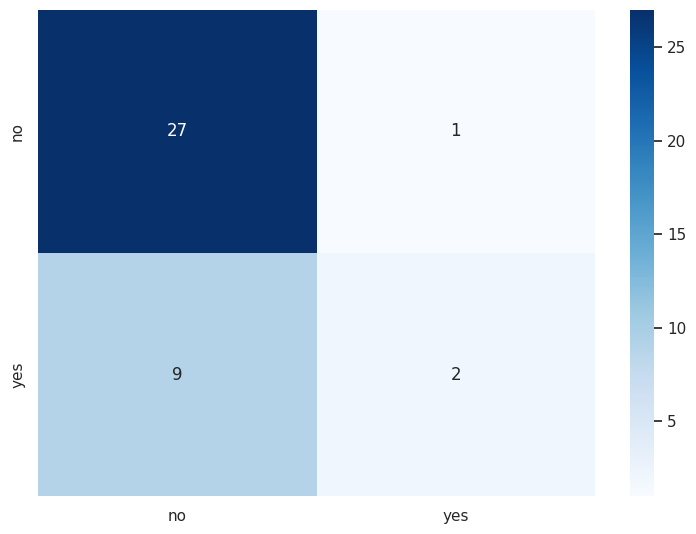

In [83]:
plt.figure(figsize=(8,6))
emotions = {0: 'no', 1: 'yes'}
emotions = list(emotions.values())
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)

In [84]:
clr = classification_report(y_true, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.75      0.96      0.84        28
           1       0.67      0.18      0.29        11

    accuracy                           0.74        39
   macro avg       0.71      0.57      0.56        39
weighted avg       0.73      0.74      0.69        39



# 5. Save model

In [85]:
import pickle
with open('tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

model.save('nlp.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# 6. Prediction function

In [86]:
def predict(text, model_path, token_path):
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    import matplotlib.pyplot as plt
    import pickle
    from tensorflow.keras.models import load_model
    
    model = load_model(model_path)
    
    
    with open(token_path, 'rb') as f:
        tokenizer = pickle.load(f)
    
    sequences = tokenizer.texts_to_sequences([text])
    x_new = pad_sequences(sequences, maxlen=50)
    predictions = model.predict([x_new, x_new])
    
    mapping = {0: 'no', 1: 'yes'}
    
    label = list(mapping.values())
    probs = list(predictions[0])
    
    max_idx = np.argmax(probs)
    
    return mapping[max_idx]
    
    

In [87]:
txt = 'I am very happy to finish this project'
predict(txt, 'nlp.h5', 'tokenizer.pkl')

1/1 [==============================] - 0s 117ms/step


'no'

In [ ]:
txt = 'I am very sad'
predict(txt, 'nlp.h5', 'tokenizer.pkl')

In [ ]:
txt = 'Ahhhhhhhhhhhh, I wanna kill myself.'
predict(txt, 'nlp.h5', 'tokenizer.pkl')

In [ ]:
txt = 'I think, i am afraid.'
predict(txt, 'nlp.h5', 'tokenizer.pkl')

In [98]:
txt = 'Ram had to decide to either order pizza or order a burger'
predict(txt, 'nlp.h5', 'tokenizer.pkl')

1/1 [==============================] - 0s 125ms/step


'yes'

In [99]:
text = val_df.iloc[10]['text']

predict(txt, 'nlp.h5', 'tokenizer.pkl')

1/1 [==============================] - 0s 123ms/step


'yes'

In [100]:
text = val_df.iloc[12]['text']

predict(txt, 'nlp.h5', 'tokenizer.pkl')

1/1 [==============================] - 0s 123ms/step


'yes'

In [92]:
val_df

,text,decision
608,andsaidthateveryninthnightaringequallyheavy wo...,no
595,"Become the ultimate end, master! Ujjain's ulti...",no
774,l'll give you company. Greetings buddy! Are yo...,yes
746,Call him. - lt's ringning. No response. - Give...,no
368,That glorious litter Ráma eyed. And spake to L...,no
742,"She looked educated but... Sister, you don't p...",no
464,"great sin for you, to have seized and brought ...",yes
487,matters. Dasaratha's troubles began with love...,no
687,ashesatinhisdwellinghetookﬂaxandyarnand worked...,no
260,fertility in the earth was one of a number of ...,no
